🔹 Loading data...
🔹 Preprocessing data...
Initial data shapes:
x_train: <class 'numpy.ndarray'> with shape (328135, 321)
x_test: <class 'numpy.ndarray'> with shape (109379, 321)
y_train: <class 'numpy.ndarray'> with shape (328135,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (321,)
useless: <class 'numpy.ndarray'> with shape (321,)
health_related: <class 'numpy.ndarray'> with shape (321,)
better_elsewhere: <class 'numpy.ndarray'> with shape (321,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (321,)
binary: <class 'numpy.ndarray'> with shape (321,)
one_hot: <class 'numpy.ndarray'> with shape (321,)
zero_values: <class 'numpy.ndarray'> with shape (321,)
default_values: <class 'numpy.ndarray'> with shape (321,)
ordinal: <class 'numpy.ndarray'> with shape (321,)
continuous: <class 'numpy.ndarray'> with shape (321,)
0 features with too many missing values dropped.

c:\Users\natha\miniforge3\envs\ml\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\natha\miniforge3\envs\ml\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


0 features with low correlation to target dropped.


c:\Users\natha\Desktop\EPFL\MilaLyon\src\preprocessing.py:395: RuntimeWarning: invalid value encountered in multiply
  clip_min = mean - n_std * std
c:\Users\natha\Desktop\EPFL\MilaLyon\src\preprocessing.py:396: RuntimeWarning: invalid value encountered in multiply
  clip_max = mean + n_std * std


Clipped 0 values in x_train (0.00% of all entries)
Clipped 0 values in x_test (0.00%)
🔹 Building polynomial features...
🔹 Training logistic regression...
✅ Training complete. Final loss: 0.4355
✅ Best threshold: 0.73 | F1_val = 0.427 | Acc_val = 0.872


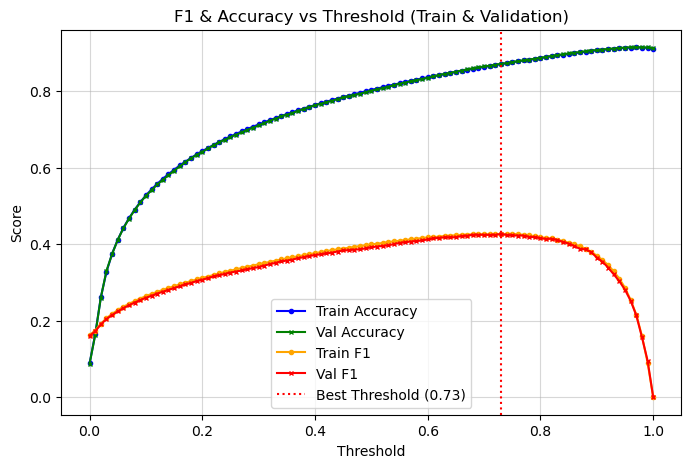

🔹 Generating predictions...
🔹 Saving predictions to 'logistic_regression_submission.csv'...
🎉 Submission file created successfully.


In [1]:
#!/usr/bin/env python3
"""
run_no_process_poly.ipynb — Logistic regression and feature expansion training script for the CVD Prediction project 
without full preprocessing .

This script:
  1. Loads and applies some processing to the BRFSS dataset.
  2. Builds polynomial features.
  3. Trains a logistic regression model.
  4. Generates predictions and plots F1, accuracy.
"""

import sys
import os

# Add the project root to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import numpy as np
from src.helpers import *
from src.implementations import *
from src.preprocessing import *
from src.crossvalidation import *
from src.model_evaluation import *

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
DATA_FOLDER = "../data/"
OUTPUT_FILE = "logistic_regression_submission.csv"

# Hyperparameters previously determined via cross-validation
BEST_GAMMA = 0.8
BEST_DEGREE = 2
MAX_ITERS = 1000
BEST_THRESHOLD = 0.17


# -------------------------------------------------------------
# Main pipeline
# -------------------------------------------------------------
def main():
    """Main pipeline: load data, preprocess, train model, predict, save."""
    print("🔹 Loading data...")
    data = load_csv_data(DATA_FOLDER, max_rows=None, dictionnary=True)

    print("🔹 Preprocessing data...")
    preprocess_data(
        data,
        nan_drop_threshold=1,
        correlation_threshold=0,
        n_std=np.inf,
        only_health_related=False,
        split_val=True,
        val_size=0.1,
        one_hot=False,
        drop_correlated=False,
    )

    print("🔹 Building polynomial features...")
    x_train_poly = build_poly(data["x_train"], BEST_DEGREE, to_expand=data["continuous"])
    x_val_poly = build_poly(data["x_val"], BEST_DEGREE, to_expand=data["continuous"])
    x_test_poly = build_poly(data["x_test"], BEST_DEGREE, to_expand=data["continuous"])

    print("🔹 Training logistic regression...")
    w_initial = np.zeros(x_train_poly.shape[1])
    weights, losses = logistic_regression(
        data["y_train"],
        x_train_poly,
        w_initial,
        MAX_ITERS,
        BEST_GAMMA,
        return_history=True,
    )
    print(f"✅ Training complete. Final loss: {losses[-1]:.4f}")


    plot_training_validation_performance(x_train_poly, data['y_train'], x_val_poly, data['y_val'], weights, losses)

    print("🔹 Generating predictions...")
    test_pred = predict_labels_logistic(x_test_poly, weights[-1], threshold=BEST_THRESHOLD)
    test_pred = np.where(test_pred == 1, 1, -1)

    print(f"🔹 Saving predictions to '{OUTPUT_FILE}'...")
    create_csv_submission(data["test_ids"], test_pred, OUTPUT_FILE)
    print("🎉 Submission file created successfully.")


# -------------------------------------------------------------
# Entry point
# -------------------------------------------------------------
if __name__ == "__main__":
    main()
